# Домашняя работа 4.1 "Классификация выживших на Титанике"

In [1]:
import pandas as pd
import numpy as np

#import warnings
#warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
#from sklearn.datasets import make_regression
#from sklearn import metrics

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

#import pandas as pd
#import numpy as np

#from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.linear_model import LogisticRegression
#from sklearn.datasets import make_regression

#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Подготовка данных

Импортируем данные, посмотрим на переменные.

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Отбор признаков

Удалим переменные PassengerId, Name и Ticket т.к. они уникальные и несут избыточную информацию. От Cabin также придётся отказаться, т.к. слишком много пропусков, хотя было бы любопытно посмотреть, обитатели каких кают и палуб выжили чаще всего.

In [4]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [6]:
(len(df) - len(df.dropna()))/len(df)

0.20089786756453423

20% датасета имеют пропущенные значения в том или ином столбце. В принципе это не так уж и много, поэтому отброшу их. В противном случае можно было бы заполнить пропуски для возраста, используя медиану во всему набору или по группам (категориям) пассажиров.

In [7]:
df = df.dropna().reset_index(drop=True)
df.shape

(712, 8)

In [8]:
179/891

0.20089786756453423

In [9]:
df.describe(include="all")

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,712.000000,712.000000,712,712.000000,712.000000,712.000000,712.000000,712
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,453,NaN,NaN,NaN,NaN,554
mean,0.404494,2.240169,NaN,29.642093,0.514045,0.432584,34.567251,NaN
std,0.491139,0.836854,NaN,14.492933,0.930692,0.854181,52.938648,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,1.000000,NaN,20.000000,0.000000,0.000000,8.050000,NaN
50%,0.000000,2.000000,NaN,28.000000,0.000000,0.000000,15.645850,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,1.000000,33.000000,NaN


In [10]:
df.nunique()

Survived      2
Pclass        3
Sex           2
Age          88
SibSp         6
Parch         7
Fare        219
Embarked      3
dtype: int64

In [11]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
707,0,3,female,39.0,0,5,29.1250,Q
708,0,2,male,27.0,0,0,13.0000,S
709,1,1,female,19.0,0,0,30.0000,S
710,1,1,male,26.0,0,0,30.0000,C


### Преобразование данных

Выбросов в данных нет. Признаки Age и Fare количественные, потребуется их нормализовать в дальнейшем. Признаки Pclass, Sex, Embarked категориальные, выполним их кодирование.

In [12]:
# Преобразовывает столбец col в набор столбцов col_categorialvalue с помощью OneHotEncoding
def OheEncode(df, col):
    enc = OneHotEncoder(handle_unknown='ignore', drop='first')
    enc_df = pd.DataFrame(enc.fit_transform(df[[col]]).toarray(), columns=[col + '_' + str(s) for s in enc.categories_[0][1:]])
    df = df.join(enc_df)
    df.drop([col], axis=1, inplace=True)
    return df

In [13]:
df2 = OheEncode(df, 'Pclass')
df2 = OheEncode(df2, 'Sex')
df2 = OheEncode(df2, 'Embarked')
df2.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0.0,1.0,1.0,0.0,1.0
1,1,38.0,1,0,71.2833,0.0,0.0,0.0,0.0,0.0
2,1,26.0,0,0,7.9250,0.0,1.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0.0,0.0,0.0,0.0,1.0
4,0,35.0,0,0,8.0500,0.0,1.0,1.0,0.0,1.0


### Разбиение на train и test

In [14]:
X = df2.drop(['Survived'], axis=1)
y = df2['Survived']
X.shape, y.shape

((712, 9), (712,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((534, 9), (178, 9), (534,), (178,))

Нормализуем Age и Fare.

In [16]:
# Заменяет столбец col на его нормализованный вариант
def ScaleColumn(df, col):
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df[[col]]), index=df.index, columns=[col+'_scaled'])
    df.drop([col], axis=1, inplace=True)
    df = df.join(scaled_df)
    return df

In [17]:
X_train = ScaleColumn(X_train, 'Age')
X_train = ScaleColumn(X_train, 'Fare')
X_train.head()

,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age_scaled,Fare_scaled
363,1,0,0.0,0.0,1.0,0.0,0.0,1.276000,1.058229
648,0,0,1.0,0.0,1.0,0.0,1.0,0.334026,-0.482687
360,0,0,0.0,0.0,1.0,0.0,1.0,1.477852,-0.090617
116,0,0,0.0,1.0,1.0,0.0,1.0,-0.204246,-0.535698
702,0,1,1.0,0.0,0.0,0.0,1.0,-0.338814,-0.178833


In [18]:
X_test = ScaleColumn(X_test, 'Age')
X_test = ScaleColumn(X_test, 'Fare')
X_test.head()

,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age_scaled,Fare_scaled
545,0,1,0.0,0.0,0.0,0.0,1.0,-1.019147,3.067339
223,1,1,0.0,1.0,0.0,0.0,1.0,0.495004,-0.217481
403,0,0,0.0,1.0,1.0,0.0,1.0,-0.034949,-0.178374
8,1,0,1.0,0.0,0.0,0.0,0.0,-1.094855,-0.048660
394,1,0,0.0,0.0,0.0,0.0,0.0,1.933448,0.779834


## Логистическая регрессия

In [19]:
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train)
train_predict = logreg.predict(X_train)
test_predict = logreg.predict(X_test)

In [20]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       322
           1       0.80      0.68      0.74       212

    accuracy                           0.81       534
   macro avg       0.80      0.78      0.79       534
weighted avg       0.80      0.81      0.80       534



In [21]:
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       102
           1       0.79      0.74      0.76        76

    accuracy                           0.80       178
   macro avg       0.80      0.79      0.80       178
weighted avg       0.80      0.80      0.80       178



Точность в среднем 0.8, что можно считать неплохим результатом. Можно заметить, что модель хуже предсказывает выживших, чем утонувших. Это подтверждается и матрицей ошибок.

In [22]:
confusion_matrix(y_train, train_predict)

array([[285,  37],
       [ 67, 145]])

In [23]:
confusion_matrix(y_test, test_predict)

array([[87, 15],
       [20, 56]])

In [24]:
y_pred_proba = logreg.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
auc = roc_auc_score(y_train, y_pred_proba)

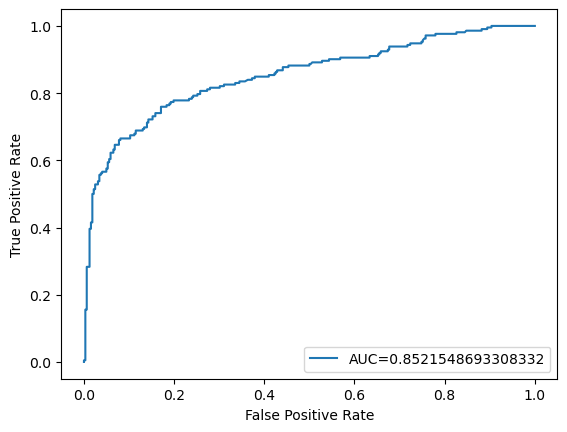

In [25]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [26]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

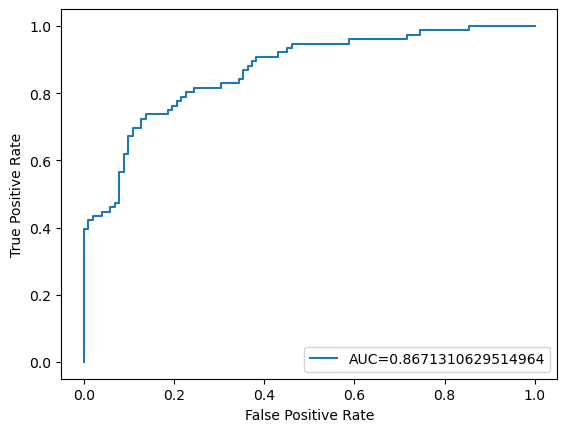

In [27]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Наша модель правильно классифицирует с вероятностью 86%.

## KNN

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
train_predict = knn.predict(X_train)
test_predict = knn.predict(X_test)

In [29]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       322
           1       0.85      0.77      0.81       212

    accuracy                           0.86       534
   macro avg       0.85      0.84      0.85       534
weighted avg       0.86      0.86      0.85       534



In [30]:
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       102
           1       0.79      0.70      0.74        76

    accuracy                           0.79       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178



На обучающем множестве KNN показало результаты лучше, чем логистическая регрессия, а на тестовом точность оказалась чуть ниже.

In [31]:
confusion_matrix(y_train, train_predict)

array([[293,  29],
       [ 48, 164]])

In [32]:
confusion_matrix(y_test, test_predict)

array([[88, 14],
       [23, 53]])

In [33]:
y_pred_proba = knn.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
auc = roc_auc_score(y_train, y_pred_proba)

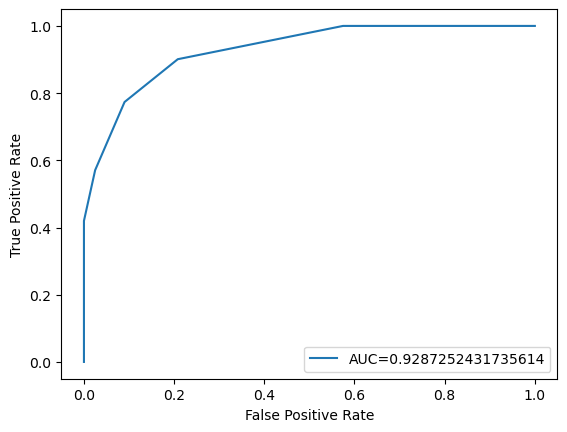

In [34]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [35]:
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

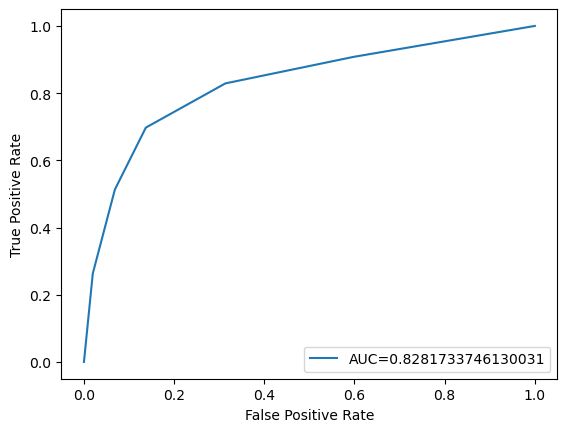

In [36]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Подбор параметров

### Логистическая регрессия

In [37]:
params = dict(
    penalty=['l1', 'l2', 'elasticnet', None],
    solver=['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    max_iter=range(50, 500, 5),
    C = np.logspace(-10, 10, 100),
    warm_start = [True, False]
)

In [38]:
logreg = LogisticRegression(random_state=0)
cv = RandomizedSearchCV(logreg, params, n_jobs=-1, cv=5, scoring='f1', n_iter=1000, random_state=0)
cv.fit(X_train, y_train)
best_params = cv.best_params_
best_params

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/l

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/l

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/l

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/l

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/l

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jack/anaconda3/envs/DE_1T/lib

{'warm_start': False,
 'solver': 'saga',
 'penalty': None,
 'max_iter': 390,
 'C': 13848.863713938747}

In [39]:
logreg = LogisticRegression(**best_params, random_state=0)
logreg.fit(X_train, y_train)
train_predict = logreg.predict(X_train)
test_predict = logreg.predict(X_test)

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [40]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       322
           1       0.79      0.69      0.74       212

    accuracy                           0.80       534
   macro avg       0.80      0.78      0.79       534
weighted avg       0.80      0.80      0.80       534



In [41]:
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       102
           1       0.78      0.75      0.77        76

    accuracy                           0.80       178
   macro avg       0.80      0.80      0.80       178
weighted avg       0.80      0.80      0.80       178



In [42]:
confusion_matrix(y_train, train_predict)

array([[282,  40],
       [ 65, 147]])

In [43]:
confusion_matrix(y_test, test_predict)

array([[86, 16],
       [19, 57]])

In [44]:
y_pred_proba = logreg.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
auc = roc_auc_score(y_train, y_pred_proba)

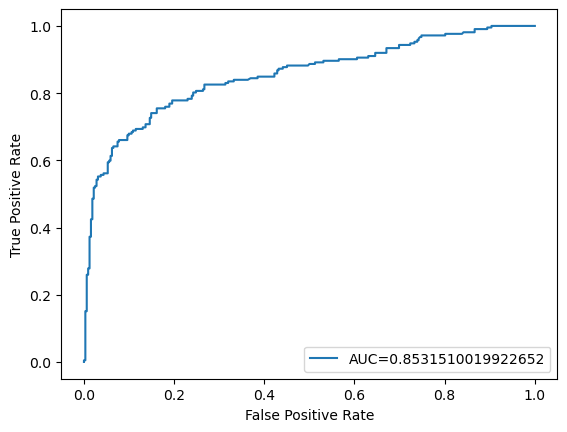

In [45]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [46]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

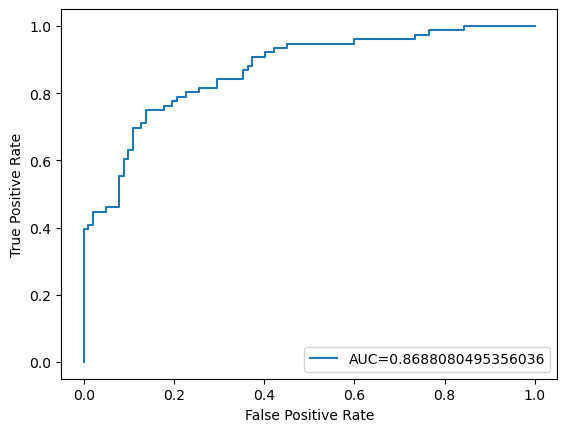

In [47]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Модель алгоритм оптимизации (солвер) на более продвинутый и повысила число итераций. Запуск с разным random_state каких-то особых предпочтений не показал, равно как и не улучшил точность.

### KNN

In [48]:
params = dict(
    n_neighbors=range(1, 40),
    weights=['uniform', 'distance'],
    algorithm=['ball_tree', 'kd_tree', 'brute'],
    metric=['cityblock', 'euclidean', 'minkowski', 'manhattan', 'chebyshev', 'cosine'],
)


In [49]:
knn = KNeighborsClassifier()
cv = RandomizedSearchCV(knn, params, n_jobs=-1, cv=5, scoring='f1', n_iter=1000, random_state=0)
cv.fit(X_train, y_train)
best_params = cv.best_params_
best_params

/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
575 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
310 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/home/jack/anaconda3/envs/DE_1T/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 493, in _fit
    se

{'weights': 'uniform',
 'n_neighbors': 12,
 'metric': 'manhattan',
 'algorithm': 'kd_tree'}

In [50]:
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)
train_predict = knn.predict(X_train)
test_predict = knn.predict(X_test)

In [51]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       322
           1       0.87      0.67      0.75       212

    accuracy                           0.83       534
   macro avg       0.84      0.80      0.81       534
weighted avg       0.83      0.83      0.82       534



In [52]:
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       102
           1       0.84      0.61      0.70        76

    accuracy                           0.78       178
   macro avg       0.80      0.76      0.76       178
weighted avg       0.79      0.78      0.77       178



In [53]:
confusion_matrix(y_train, train_predict)

array([[300,  22],
       [ 71, 141]])

In [54]:
confusion_matrix(y_test, test_predict)

array([[93,  9],
       [30, 46]])

In [55]:
y_pred_proba = knn.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
auc = roc_auc_score(y_train, y_pred_proba)

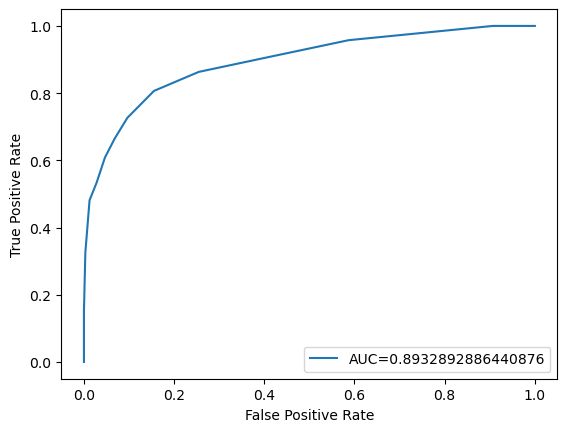

In [56]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [57]:
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

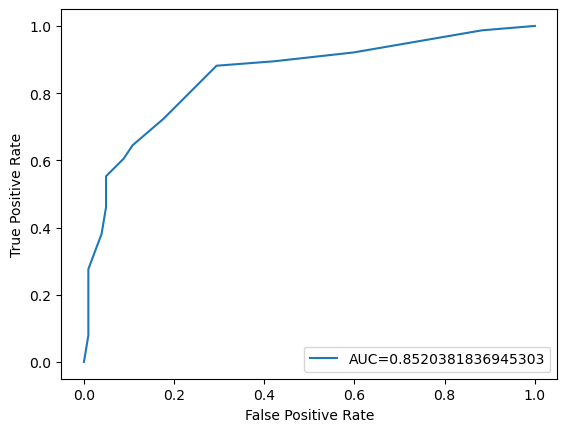

In [58]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Точность классификации на тестовом множестве слегка повысилась. Главный параметр, который как мне кажется повлиял на это - число соседей, увеличение которого позволило провести более "извилистую" границу между классами. Также интересно было бы более подробно изучить влияние различных метрик на точность.

Однако логистическая регрессия по-прежнему даёт лучшие результаты, что несколько странно. Возможно это связано с избыточными переменными в исходном датасете, которые кореллируют друг с другом.